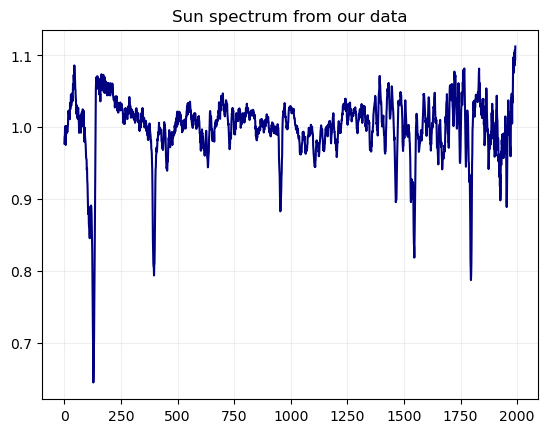

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from imageio import imwrite, imread
from matplotlib.pyplot import figure, show, close, xlabel, ylabel, title
from scipy.constants import k, h, c, e
import sympy as sp
from scipy.optimize import curve_fit
from astropy.visualization import simple_norm, MinMaxInterval

sun_data = np.loadtxt("flatlined/Flatlined_Moon.txt", comments="#")

fig = figure()
frame = fig.add_subplot(1, 1, 1)
frame.plot(sun_data, color="navy", label="Vega spectrum")
frame.set_title("Sun spectrum from our data")
frame.grid(alpha=0.2)
show()
close(fig)

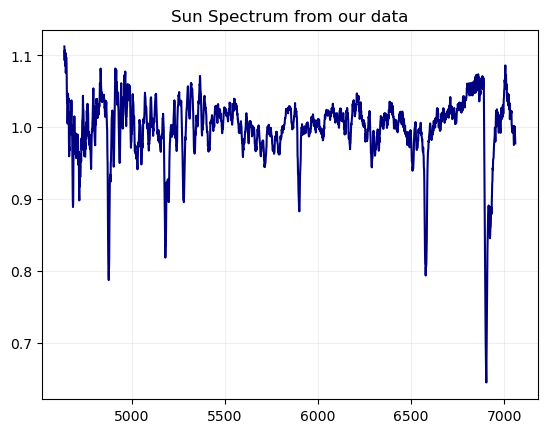

In [5]:
x_range = np.arange(0, np.size(sun_data))
x_range_a = x_range*-1.217+7060

fig=figure()
frame=fig.add_subplot(1,1,1)
frame.plot(x_range_a,sun_data,color="navy", label="Arcturus spectrum") # the section of the data that seems relevant
frame.set_title("Sun Spectrum from our data")
frame.grid(alpha=0.2)
show()
close(fig)